In [4]:
from sklearn.datasets import make_circles

#Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise = 0.03, # a little bit of noise to the dots
                    random_state=42) # Keep random state so we get the same values

In [5]:
print (f"First 5 X features:\n{X[:5]}")
print(f"First 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 y labels:
[1 1 1 1 0]


In [6]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [7]:
# Checking different labels
circles.label.value_counts()

,count
label,
1,500
0,500


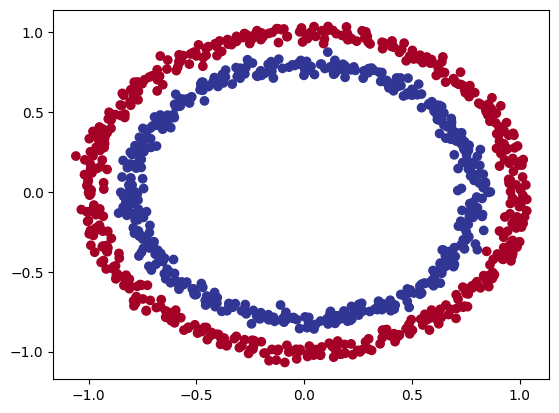

In [8]:
#visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);


In [9]:
X.shape, y.shape

((1000, 2), (1000,))

In [10]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X : {X_sample} and the same for y:{y_sample}")
print(f" Shapes for one sample of X :{X_sample.shape} and the same for y:{y_sample.shape}")


Values for one sample of X : [0.75424625 0.23148074] and the same for y:1
 Shapes for one sample of X :(2,) and the same for y:()


## Turning Data into tensors and create train and test splits

In [11]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


#view the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size =0.2,
                                                 random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Building a model
1. Set up device agnostic code ( so our model can run on CPU or GPU if its available)
2. Constructing a model by subclassing nn.Module
3. Defining loss function and optimizer
4. Creating a training loop

In [13]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
# 1. Construct a model class that subclasses nn.Module
class CirclModelV0(nn.Module):
  def __init__(self):
      super().__init__()
      # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
      self.layer_1 = nn.Linear(in_features=2, out_features=5)
      self.layer_2 = nn.Linear(in_features=5, out_features=1)
  # 3. Define a forward method containing the forward pass computation
  def forward(self,x):
    # Return the output of layer_2, a single feature, the same shape as y
    return self.layer_2(self.layer_1(x))

# 4. Create an instance of the model and send it to target device
model_0 = CirclModelV0().to(device)
model_0


CirclModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
# # Replicate CircleModelV0 with nn.Sequential
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=5),
#     nn.Linear(in_features=5, out_features=1)
# ).to(device)

# model_0

In [16]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[ 0.2051],
        [ 0.0823],
        [ 0.2490],
        [ 0.1938],
        [-0.1923],
        [-0.2638],
        [-0.2598],
        [-0.3420],
        [ 0.2675],
        [ 0.0692]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [17]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

## Creating Evaluation Metrics

In [18]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

## Training Model

In [19]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.2051],
        [ 0.0823],
        [ 0.2490],
        [ 0.1938],
        [-0.1923]], device='cuda:0', grad_fn=<SliceBackward0>)

In [20]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5511],
        [0.5206],
        [0.5619],
        [0.5483],
        [0.4521]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [21]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [22]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### Building a training and testing loop

In [23]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70096, Accuracy: 50.50% | Test loss: 0.69764, Test acc: 49.00%
Epoch: 10 | Loss: 0.69934, Accuracy: 50.50% | Test loss: 0.69622, Test acc: 49.50%
Epoch: 20 | Loss: 0.69814, Accuracy: 50.00% | Test loss: 0.69522, Test acc: 49.00%
Epoch: 30 | Loss: 0.69724, Accuracy: 50.12% | Test loss: 0.69449, Test acc: 48.50%
Epoch: 40 | Loss: 0.69653, Accuracy: 50.12% | Test loss: 0.69396, Test acc: 49.50%
Epoch: 50 | Loss: 0.69597, Accuracy: 50.25% | Test loss: 0.69356, Test acc: 49.00%
Epoch: 60 | Loss: 0.69553, Accuracy: 50.38% | Test loss: 0.69326, Test acc: 49.00%
Epoch: 70 | Loss: 0.69517, Accuracy: 50.38% | Test loss: 0.69304, Test acc: 49.50%
Epoch: 80 | Loss: 0.69487, Accuracy: 50.12% | Test loss: 0.69288, Test acc: 49.50%
Epoch: 90 | Loss: 0.69463, Accuracy: 50.12% | Test loss: 0.69276, Test acc: 50.00%


In [24]:
# Create helper_functions.py if it doesn't exist
# You would need to fill in the actual implementations of these functions
# This is a placeholder to resolve the import error

"""
Helper functions for PyTorch model training and evaluation.
"""

def plot_predictions(train_data, train_labels, test_data, test_labels, predictions=None):
    """
    Plots training data, testing data and compares predictions.
    """
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=40, cmap=plt.cm.RdYlBu, label="Train data")
    plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, s=40, cmap=plt.cm.RdYlBu, label="Test data")
    if predictions is not None:
        plt.scatter(test_data[:, 0], test_data[:, 1], c=predictions, s=40, cmap=plt.cm.RdYlBu, marker='x', label="Predictions")
    plt.legend(loc="best")
    plt.title("Train, Test and Prediction Data")
    plt.show()

def plot_decision_boundary(model, X, y):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source: https://madewithml.com/courses/basics/plotting-decision-boundaries/
     & https://github.com/pytorch/tutorials/blob/main/beginner_source/basics/quickstart_tutorial.py
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # 0. Setup prediction boundaries and make grid of 100x100 points
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # 1. Make features
    X_to_pred_on = torch.from_numpy(np.vstack((xx.ravel(), yy.ravel())).T).float()

    # 2. Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust accordingly
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # 3. Plot training examples and decision boundary
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

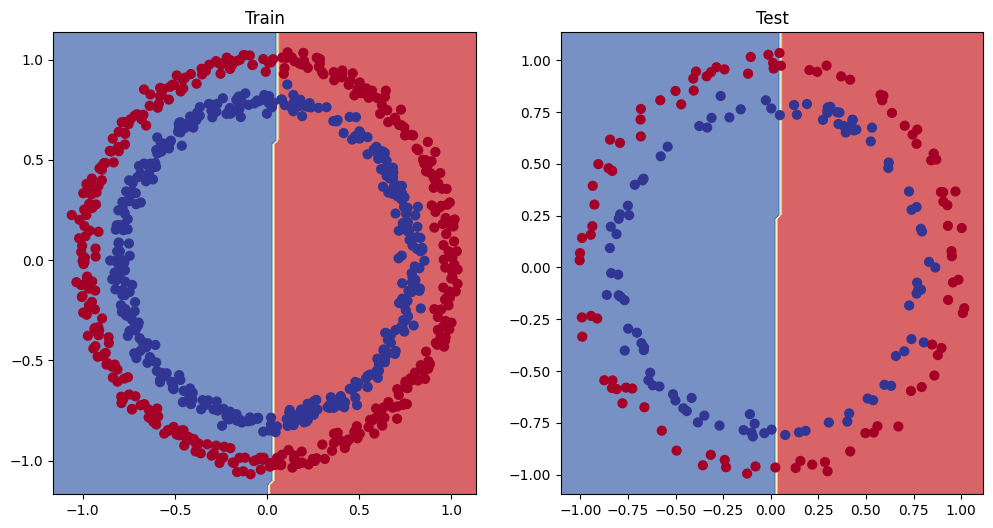

In [26]:
import numpy as np

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# Creating Non- Linearity
Our Data is not a linear data so we need to create a model that would be able to learn non-linear data.

####Building a model with non-linearity

In [27]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [28]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

#####Training a model with non-linearity

In [29]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


#####Evaluating a model trained with non-linear activitation function

In [30]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

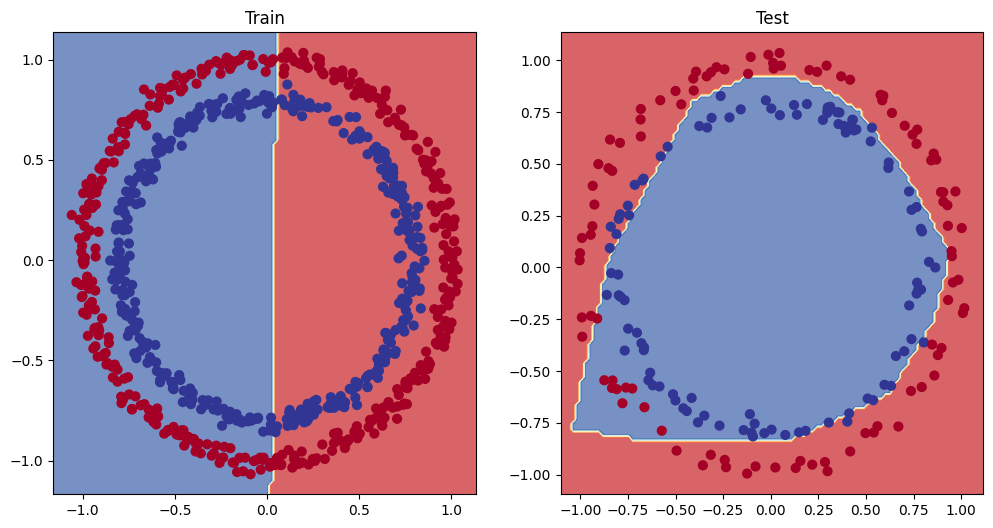

In [31]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

## Saving the Model

In [32]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "02_pytorch_NN _Binary_classification.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_3.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/02_pytorch_NN _Binary_classification.pth
